# Detecting Phishing Websites with Machine Learning
### Security for Networked Systems – Final Project
**Author:** Sahithi Reddy Senagapally (ssenaga@iu.edu)

## Overview
This project aims to detect phishing websites using Machine Learning by analyzing URL-based, domain-based, and content-based features. Phishing websites are crafted to deceive users into revealing sensitive information such as passwords or credit card numbers. The goal of this project is to automatically classify a website as *legitimate* or *phishing* by learning discriminative patterns from labeled data.

## Dataset
The dataset used for this project was obtained from publicly available repositories on Kaggle, containing thousands of labeled URLs. Each record includes a website URL and a binary label:
- **1** → Phishing  
- **0** → Legitimate  

The dataset features were engineered from the raw URLs to extract over 50 lexical and structural indicators, such as:
- URL length, number of dots, hyphens, and “@” symbols  
- Presence of HTTPS, IP address usage, or shortening services  
- Entropy of URL strings  
- SSL certificate validity and domain age (where available)  

## Methodology
1. **Feature Engineering:** Extracted lexical, host-based, and domain-level features from URLs using Python’s `re`, `socket`, and `ssl` modules.  
2. **Data Preprocessing:** Standardized the features using `StandardScaler`.  
3. **Model Training:** Implemented and compared multiple classical ML models, including:
   - Logistic Regression  
   - Decision Tree  
   - Random Forest  
   - K-Nearest Neighbors  
   - Support Vector Machine (SVC)  
   - Naive Bayes  
   - Multi-Layer Perceptron (MLP)  
4. **Evaluation Metrics:** Models were evaluated using accuracy, precision, recall, F1-score, ROC-AUC, and confusion matrix visualizations.

## Tools & Libraries
- **Python 3**, **Scikit-learn**, **Pandas**, **NumPy**, **Matplotlib**
- Jupyter Notebook for experimentation and visualization

## Objective
To determine which ML model achieves the highest accuracy and generalization in detecting phishing URLs, and to analyze the contribution of different URL-based features to phishing detection performance.


In [1]:
import os
import re
import math
import socket
import ssl
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay
)

# Classical ML models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

rcParams["figure.figsize"] = (7, 5)
plt.style.use("default")
RANDOM_STATE = 42

print("Imports loaded.")


Imports loaded.


In [2]:
DATA_PATH = "phishing data.csv"
df = pd.read_csv('phishing data.csv', index_col = 0)
df.head()

,url,status
0,http://www.crestonwood.com/router.php,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,phishing
2,https://support-appleld.com.secureupdate.duila...,phishing
3,http://rgipt.ac.in,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate


Unique values in status: ['legitimate' 'phishing']

Label distribution:
label
0    5715
1    5715
Name: count, dtype: int64


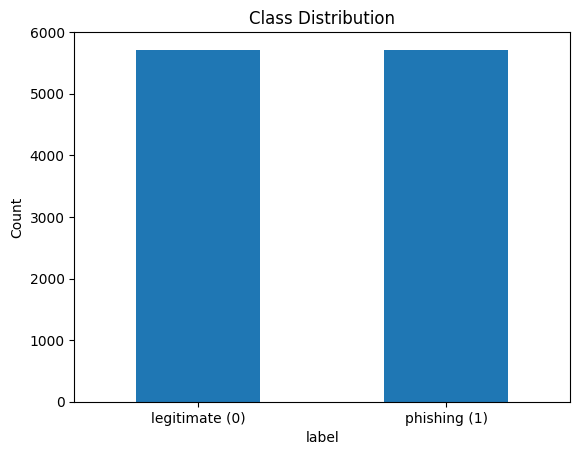

In [3]:
print("Unique values in status:", df["status"].unique())

# Encode label: phishing -> 1, legitimate/benign -> 0
status_map = {
    "phishing": 1,
    "legitimate": 0,
    "benign": 0,
    "safe": 0
}

# If status is already numeric, keep it; otherwise map
if df["status"].dtype == object:
    df["label"] = df["status"].str.lower().map(status_map)
else:
    df["label"] = df["status"].astype(int)

# Drop rows where label could not be mapped
df = df.dropna(subset=["label"]).copy()
df["label"] = df["label"].astype(int)

print("\nLabel distribution:")
print(df["label"].value_counts())

df["label"].value_counts().plot(kind="bar")
plt.xticks([0,1], ["legitimate (0)", "phishing (1)"], rotation=0)
plt.title("Class Distribution")
plt.ylabel("Count")
plt.show()


## 1. Preprocessing and Feature Engineering

We now build a **full-fledged feature set** (50+ columns) from the URL itself:

### Lexical Features (examples)
- URL length, hostname length, path length, query length
- Number of special characters: `.`, `-`, `_`, `/`, `?`, `=`, `&`, `%`, `@`
- Number of digits, letters, digit/letter ratios
- Number of subdirectories, number of query parameters
- Shannon entropy of the URL
- Presence of `http`, `https`, `www`, IP address in domain
- Suspicious keywords: `login`, `verify`, `update`, `secure`, `account`, `bank`, `confirm`, `paypal`, `amazon`, `ebay`, `signin`, `password`

### Domain-Based Features (via tldextract & WHOIS)
- Domain name, suffix
- Domain length, digit count, hyphen count
- Country-code TLD flag (e.g., `.in`, `.ru`, etc.)
- WHOIS-based features:
  - Has WHOIS data
  - Domain age in days
  - Days until expiry
  - Registrar name length

### SSL/TLS Features
- Uses HTTPS or not
- Attempt to retrieve certificate:
  - Has certificate
  - Certificate validity days (if available)
  - Issuer text length

To avoid runtime issues, WHOIS and SSL calls use **safe try/except** and a cache so the same domain is not queried repeatedly.


In [4]:
# Flags: turn these off if no internet or if TOO SLOW
DO_WHOIS = False   # set to True if you want real WHOIS queries
DO_SSL = False     # set to True if you want real SSL certificate queries

whois_cache = {}
ssl_cache = {}

print("Domain tools ready. DO_WHOIS =", DO_WHOIS, ", DO_SSL =", DO_SSL)


Domain tools ready. DO_WHOIS = False , DO_SSL = False


In [5]:
def shannon_entropy(s: str) -> float:
    s = s or ""
    if len(s) == 0:
        return 0.0
    freq = {}
    for ch in s:
        freq[ch] = freq.get(ch, 0) + 1
    probs = [c / len(s) for c in freq.values()]
    return -sum(p * math.log2(p) for p in probs)

def has_ip_address(host: str) -> int:
    # rough IP pattern
    ip_pattern = r'^(\d{1,3}\.){3}\d{1,3}$'
    return int(bool(re.match(ip_pattern, host)))

SHORTENERS = [
    "bit.ly", "goo.gl", "tinyurl.com", "ow.ly", "t.co", "is.gd", "buff.ly",
    "adf.ly", "bitly.com", "rebrand.ly"
]

SUSPICIOUS_KEYWORDS = [
    "login", "log-in", "verify", "verification", "update", "secure", "account",
    "bank", "paypal", "amazon", "ebay", "signin", "sign-in", "password",
    "confirm", "security", "billing"
]


In [6]:
def get_whois_features(domain: str):
    """
    Return WHOIS-based features: has_whois, domain_age_days, expiry_days, registrar_len.
    Uses cache and safe try/except.
    """
    if not DO_WHOIS or whois is None:
        return {
            "has_whois": 0,
            "domain_age_days": 0,
            "expiry_days": 0,
            "registrar_len": 0
        }

    domain = domain.lower()
    if domain in whois_cache:
        return whois_cache[domain]

    result = {
        "has_whois": 0,
        "domain_age_days": 0,
        "expiry_days": 0,
        "registrar_len": 0
    }

    try:
        w = whois.whois(domain)
        result["has_whois"] = 1

        creation = w.creation_date
        expiration = w.expiration_date
        now = datetime.utcnow()

        # Some WHOIS libraries return lists
        if isinstance(creation, list):
            creation = creation[0]
        if isinstance(expiration, list):
            expiration = expiration[0]

        if isinstance(creation, datetime):
            result["domain_age_days"] = max((now - creation).days, 0)
        if isinstance(expiration, datetime):
            result["expiry_days"] = max((expiration - now).days, 0)

        registrar = w.registrar
        if registrar:
            result["registrar_len"] = len(str(registrar))

    except Exception:
        # Keep defaults on error
        pass

    whois_cache[domain] = result
    return result


def get_ssl_features(host: str):
    """
    Return SSL-based features: has_cert, cert_valid_days, issuer_len.
    Uses cache and safe try/except.
    """
    if not DO_SSL:
        return {
            "has_cert": 0,
            "cert_valid_days": 0,
            "issuer_len": 0
        }

    host = host.lower()
    if host in ssl_cache:
        return ssl_cache[host]

    result = {
        "has_cert": 0,
        "cert_valid_days": 0,
        "issuer_len": 0
    }

    try:
        context = ssl.create_default_context()
        with socket.create_connection((host, 443), timeout=3) as sock:
            with context.wrap_socket(sock, server_hostname=host) as ssock:
                cert = ssock.getpeercert()
                result["has_cert"] = 1

                # NotBefore and NotAfter are strings
                not_before = cert.get("notBefore")
                not_after = cert.get("notAfter")
                date_format = "%b %d %H:%M:%S %Y %Z"

                if not_before and not_after:
                    nb = datetime.strptime(not_before, date_format)
                    na = datetime.strptime(not_after, date_format)
                    result["cert_valid_days"] = max((na - nb).days, 0)

                issuer = cert.get("issuer")
                result["issuer_len"] = len(str(issuer)) if issuer else 0

    except Exception:
        pass

    ssl_cache[host] = result
    return result


In [7]:
try:
    import tldextract
except ImportError:
    tldextract = None

def extract_url_features(url: str) -> dict:
    url = str(url).strip()
    url_lower = url.lower()

    # Basic URL components
    protocol = "http"
    if "://" in url_lower:
        protocol = url_lower.split("://", 1)[0]

    rest = url_lower.split("://", 1)[1] if "://" in url_lower else url_lower
    parts = rest.split("/", 1)
    host = parts[0]
    path_query = parts[1] if len(parts) > 1 else ""
    path = path_query.split("?", 1)[0]
    query = path_query[len(path)+1:] if "?" in path_query else ""

    # Length-based features
    url_length = len(url_lower)
    host_length = len(host)
    path_length = len(path)
    query_length = len(query)

    # Character counts
    num_dots = url_lower.count(".")
    num_hyphens = url_lower.count("-")
    num_underscores = url_lower.count("_")
    num_slash = url_lower.count("/")
    num_question = url_lower.count("?")
    num_equal = url_lower.count("=")
    num_ampersand = url_lower.count("&")
    num_percent = url_lower.count("%")
    num_at = url_lower.count("@")

    num_digits = sum(ch.isdigit() for ch in url_lower)
    num_letters = sum(ch.isalpha() for ch in url_lower)
    digit_ratio = num_digits / url_length if url_length > 0 else 0
    letter_ratio = num_letters / url_length if url_length > 0 else 0

    # Path and query structure
    num_subdirs = path.count("/")
    num_params = query.count("&") + (1 if "=" in query else 0)

    # Entropy
    entropy = shannon_entropy(url_lower)

    # Protocol flags
    has_https = int(protocol == "https")
    has_http = int(protocol.startswith("http"))
    has_www = int("www." in host)

    # Shortener + IP flags
    is_shortened = int(any(short in host for short in SHORTENERS))
    ip_in_domain = has_ip_address(host)

    # Suspicious keywords
    keyword_features = {}
    for kw in SUSPICIOUS_KEYWORDS:
        keyword_features[f"kw_{kw.replace('-', '_')}"] = int(kw in url_lower)

    # Domain-based (tldextract)
    domain_features = {
        "domain_len": 0,
        "domain_num_digits": 0,
        "domain_num_hyphens": 0,
        "subdomain_len": 0,
        "suffix_len": 0,
        "is_country_tld": 0,
        "tld_is_com": 0,
        "tld_is_net": 0,
        "tld_is_org": 0,
        "tld_is_in": 0,
        "tld_is_ru": 0,
        "tld_is_info": 0,
    }

    domain = ""
    suffix = ""

    if tldextract is not None:
        ext = tldextract.extract(url_lower)
        subdomain = ext.subdomain or ""
        domain = ext.domain or ""
        suffix = ext.suffix or ""

        domain_full = domain
        domain_features["domain_len"] = len(domain_full)
        domain_features["domain_num_digits"] = sum(ch.isdigit() for ch in domain_full)
        domain_features["domain_num_hyphens"] = domain_full.count("-")
        domain_features["subdomain_len"] = len(subdomain)
        domain_features["suffix_len"] = len(suffix)

        # ccTLD ~ 2 letters
        domain_features["is_country_tld"] = int(len(suffix) == 2)

        suf = suffix.split(".")[-1] if suffix else ""
        domain_features["tld_is_com"] = int(suf == "com")
        domain_features["tld_is_net"] = int(suf == "net")
        domain_features["tld_is_org"] = int(suf == "org")
        domain_features["tld_is_in"]  = int(suf == "in")
        domain_features["tld_is_ru"]  = int(suf == "ru")
        domain_features["tld_is_info"] = int(suf == "info")

    # WHOIS features
    whois_feats = get_whois_features(domain) if domain else {
        "has_whois": 0,
        "domain_age_days": 0,
        "expiry_days": 0,
        "registrar_len": 0
    }

    # SSL features
    ssl_feats = get_ssl_features(host)

    features = {
        # lengths
        "url_length": url_length,
        "host_length": host_length,
        "path_length": path_length,
        "query_length": query_length,

        # character counts
        "num_dots": num_dots,
        "num_hyphens": num_hyphens,
        "num_underscores": num_underscores,
        "num_slash": num_slash,
        "num_question": num_question,
        "num_equal": num_equal,
        "num_ampersand": num_ampersand,
        "num_percent": num_percent,
        "num_at": num_at,

        # digits/letters
        "num_digits": num_digits,
        "num_letters": num_letters,
        "digit_ratio": digit_ratio,
        "letter_ratio": letter_ratio,

        # structure
        "num_subdirs": num_subdirs,
        "num_params": num_params,

        # entropy, protocol, host
        "entropy": entropy,
        "has_https": has_https,
        "has_http": has_http,
        "has_www": has_www,
        "is_shortened": is_shortened,
        "ip_in_domain": ip_in_domain,
    }

    features.update(keyword_features)
    features.update(domain_features)
    features.update(whois_feats)
    features.update(ssl_feats)

    return features


In [8]:
feature_dicts = df["url"].apply(extract_url_features)
features_df = pd.DataFrame(list(feature_dicts))
print("Feature DataFrame shape:", features_df.shape)

features_df.head()

Feature DataFrame shape: (11430, 61)


,url_length,host_length,path_length,query_length,num_dots,num_hyphens,num_underscores,num_slash,num_question,num_equal,...,tld_is_in,tld_is_ru,tld_is_info,has_whois,domain_age_days,expiry_days,registrar_len,has_cert,cert_valid_days,issuer_len
0,37,19,10,0,3,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
1,77,23,46,0,1,0,0,5,0,0,...,0,0,0,0,0,0,0,0,0,0
2,126,50,19,47,4,1,2,5,1,3,...,0,0,0,0,0,0,0,0,0,0
3,18,11,0,0,2,0,0,2,0,0,...,1,0,0,0,0,0,0,0,0,0
4,55,15,32,0,2,2,0,5,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
features_df.describe()

,url_length,host_length,path_length,query_length,num_dots,num_hyphens,num_underscores,num_slash,num_question,num_equal,...,tld_is_in,tld_is_ru,tld_is_info,has_whois,domain_age_days,expiry_days,registrar_len,has_cert,cert_valid_days,issuer_len
count,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,...,11430.000000,11430.000000,11430.000000,11430.0,11430.0,11430.0,11430.0,11430.0,11430.0,11430.0
mean,61.120035,21.104024,22.444357,9.102625,2.480665,0.997550,0.322660,4.289589,0.141207,0.293176,...,0.006912,0.025722,0.003500,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,55.292470,10.785881,28.401251,44.469379,1.369685,2.087087,1.093336,1.882251,0.364456,0.998317,...,0.082852,0.158311,0.059056,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,12.000000,4.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,33.000000,15.000000,0.000000,0.000000,2.000000,0.000000,0.000000,3.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,47.000000,19.000000,16.000000,0.000000,2.000000,0.000000,0.000000,4.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,71.000000,24.000000,32.000000,0.000000,3.000000,1.000000,0.000000,5.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1641.000000,214.000000,601.000000,1585.000000,24.000000,43.000000,18.000000,33.000000,3.000000,19.000000,...,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
X = features_df
y = df["label"].values

print("Final feature matrix shape:", X.shape)
print("Number of features:", X.shape[1])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train:", X_train.shape, "Test:", X_test.shape)


Final feature matrix shape: (11430, 61)
Number of features: 61
Train: (9144, 61) Test: (2286, 61)


## 2. Exploratory Data Analysis (EDA)

We now inspect:
- Basic summary statistics of the engineered features.
- Correlation of features with the phishing label.
- Distribution of a few important features.


In [11]:
# Basic statistics
display(X.describe().T.head(15))

# Correlation with label
corr_df = features_df.copy()
corr_df["label"] = y
corr = corr_df.corr(numeric_only=True)["label"].sort_values(ascending=False)

print("Top 10 positively correlated features with phishing (label=1):")
print(corr.head(10))

print("\nTop 10 negatively correlated features with phishing (label=1):")
print(corr.tail(10))


,count,mean,std,min,25%,50%,75%,max
url_length,11430.0,61.120035,55.292470,12.0,33.0,47.0,71.0,1641.0
host_length,11430.0,21.104024,10.785881,4.0,15.0,19.0,24.0,214.0
path_length,11430.0,22.444357,28.401251,0.0,0.0,16.0,32.0,601.0
query_length,11430.0,9.102625,44.469379,0.0,0.0,0.0,0.0,1585.0
num_dots,11430.0,2.480665,1.369685,1.0,2.0,2.0,3.0,24.0
num_hyphens,11430.0,0.997550,2.087087,0.0,0.0,0.0,1.0,43.0
num_underscores,11430.0,0.322660,1.093336,0.0,0.0,0.0,0.0,18.0
num_slash,11430.0,4.289589,1.882251,2.0,3.0,4.0,5.0,33.0
num_question,11430.0,0.141207,0.364456,0.0,0.0,0.0,0.0,3.0
num_equal,11430.0,0.293176,0.998317,0.0,0.0,0.0,0.0,19.0


Top 10 positively correlated features with phishing (label=1):
label            1.000000
digit_ratio      0.356421
entropy          0.344416
num_question     0.294319
url_length       0.248482
subdomain_len    0.246066
num_slash        0.242270
num_digits       0.240425
num_subdirs      0.240396
host_length      0.238706
Name: label, dtype: float64

Top 10 negatively correlated features with phishing (label=1):
letter_ratio      -0.229311
has_www           -0.465455
has_http                NaN
has_whois               NaN
domain_age_days         NaN
expiry_days             NaN
registrar_len           NaN
has_cert                NaN
cert_valid_days         NaN
issuer_len              NaN
Name: label, dtype: float64


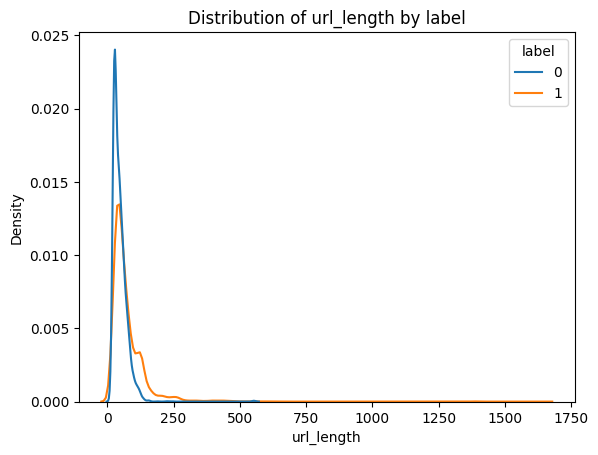

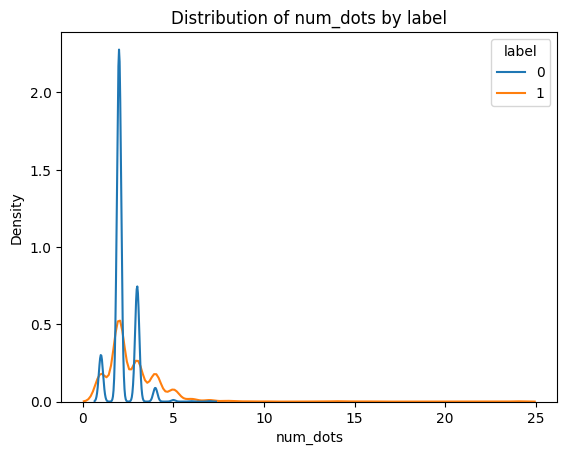

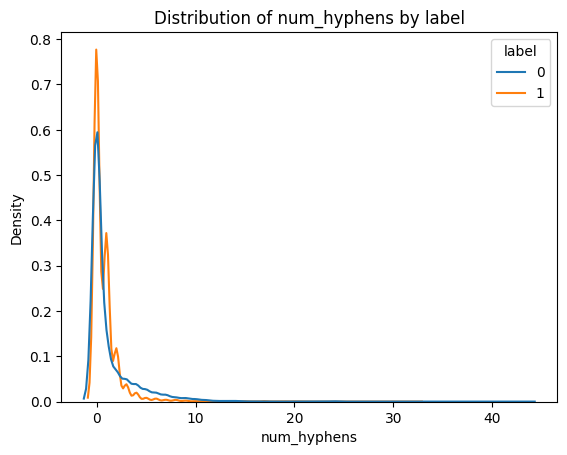

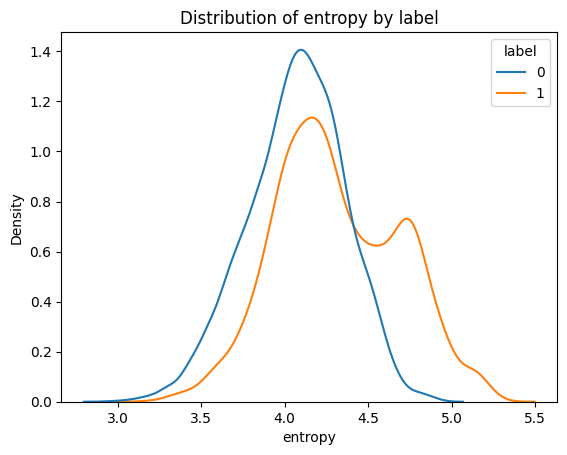

In [12]:
import seaborn as sns

for feat in ["url_length", "num_dots", "num_hyphens", "entropy"]:
    if feat in X.columns:
        plt.figure()
        sns.kdeplot(x=features_df[feat], hue=df["label"], common_norm=False)
        plt.title(f"Distribution of {feat} by label")
        plt.xlabel(feat)
        plt.ylabel("Density")
        plt.show()


## 3. Model Training and Hyperparameter Tuning

We train **7 models**:
- 5 classical ML models:
  1. Logistic Regression  
  2. Linear SVM (`LinearSVC`)  
  3. RBF SVM (`SVC`)  
  4. K-Nearest Neighbors  
  5. Gaussian Naive Bayes  
- 1 ensemble:
  6. Random Forest  
- 1 neural network:
  7. MLPClassifier (simple feedforward neural network)

For each, we use a small hyperparameter grid and `GridSearchCV` (3-fold CV)
with F1-score as the optimization metric.


In [13]:
models_and_parameters = {
    "Logistic Regression": {
        "estimator": LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
        "param_grid": {
            "C": [0.01, 0.1, 1, 10],
            "class_weight": [None, "balanced"]
        },
        "use_scaled": True
    },
    "Linear SVM": {
        "estimator": LinearSVC(random_state=RANDOM_STATE, max_iter=5000),
        "param_grid": {
            "C": [0.01, 0.1, 1, 10],
            "loss": ["hinge", "squared_hinge"]
        },
        "use_scaled": True
    },
    "RBF SVM": {
        "estimator": SVC(random_state=RANDOM_STATE),
        "param_grid": {
            "C": [0.1, 1, 10],
            "gamma": ["scale", "auto"]
        },
        "use_scaled": True
    },
    "KNN": {
        "estimator": KNeighborsClassifier(),
        "param_grid": {
            "n_neighbors": [3, 5, 7, 11],
            "weights": ["uniform", "distance"],
            "metric": ["euclidean", "manhattan"]
        },
        "use_scaled": True
    },
    "Gaussian NB": {
        "estimator": GaussianNB(),
        "param_grid": {
            "var_smoothing": [1e-9, 1e-8, 1e-7]
        },
        "use_scaled": True
    },
    "Random Forest": {
        "estimator": RandomForestClassifier(random_state=RANDOM_STATE),
        "param_grid": {
            "n_estimators": [100, 300],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5]
        },
        "use_scaled": False  # trees don't need scaling
    },
    "MLP Neural Net": {
        "estimator": MLPClassifier(random_state=RANDOM_STATE, max_iter=500),
        "param_grid": {
            "hidden_layer_sizes": [(64,), (128,), (64,32)],
            "alpha": [1e-4, 1e-3],
            "learning_rate_init": [0.001, 0.01]
        },
        "use_scaled": True
    }
}

print("Models configured:", list(models_and_parameters.keys()))


Models configured: ['Logistic Regression', 'Linear SVM', 'RBF SVM', 'KNN', 'Gaussian NB', 'Random Forest', 'MLP Neural Net']


## 4. Evaluation and Metrics Logging

For each tuned model, we evaluate on the test set and log:

- Accuracy  
- Precision  
- Recall  
- F1-score  
- ROC-AUC  

We also:
- Print classification report  
- Plot confusion matrix  
- Plot ROC curve (when possible)  

All results are stored in a **metrics log** DataFrame to compare models.


In [14]:
def evaluate_and_log(name, model, X_test_m, y_test, log_list, best_params=None, cv_best_score=None):
    # Predict
    y_pred = model.predict(X_test_m)

    # Scores for ROC
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test_m)[:, 1]
    elif hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test_m)
    else:
        y_scores = y_pred  # fallback

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    try:
        roc_auc = roc_auc_score(y_test, y_scores)
    except ValueError:
        roc_auc = float("nan")

    print(f"\n{'='*60}\nModel: {name}\n{'='*60}")
    print("Best Params:", best_params)
    if cv_best_score is not None:
        print(f"Best CV F1 Score: {cv_best_score:.4f}")
    print(f"Test Accuracy : {acc:.4f}")
    print(f"Test Precision: {prec:.4f}")
    print(f"Test Recall   : {rec:.4f}")
    print(f"Test F1-score : {f1:.4f}")
    print(f"Test ROC-AUC  : {roc_auc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)

    # Confusion matrix plot
    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(f"{name} - Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Legit (0)", "Phish (1)"])
    ax.set_yticklabels(["Legit (0)", "Phish (1)"])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="black")
    plt.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

    # ROC curve
    try:
        RocCurveDisplay.from_predictions(y_test, y_scores)
        plt.title(f"{name} - ROC Curve")
        plt.show()
    except Exception as e:
        print("Could not plot ROC curve:", e)

    # Log metrics
    log_list.append({
        "model": name,
        "best_params": best_params,
        "cv_best_f1": cv_best_score,
        "test_accuracy": acc,
        "test_precision": prec,
        "test_recall": rec,
        "test_f1": f1,
        "test_roc_auc": roc_auc
    })




##### Tuning model: Logistic Regression #####
Best params: {'C': 1, 'class_weight': None}
Best CV F1: 0.8336
Tuning time: 2.36 seconds

Model: Logistic Regression
Best Params: {'C': 1, 'class_weight': None}
Best CV F1 Score: 0.8336
Test Accuracy : 0.8311
Test Precision: 0.8243
Test Recall   : 0.8416
Test F1-score : 0.8329
Test ROC-AUC  : 0.9206

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1143
           1       0.82      0.84      0.83      1143

    accuracy                           0.83      2286
   macro avg       0.83      0.83      0.83      2286
weighted avg       0.83      0.83      0.83      2286

Confusion Matrix:
 [[938 205]
 [181 962]]


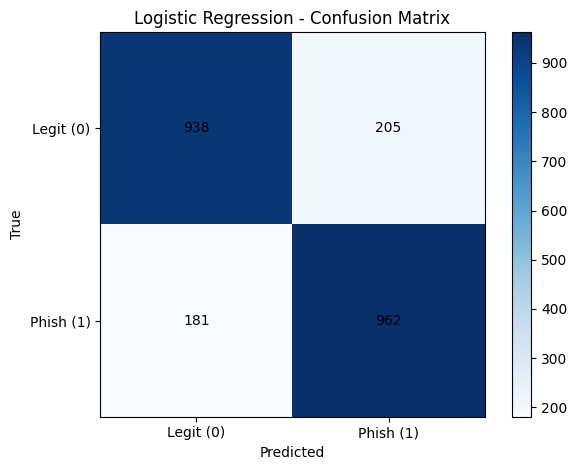

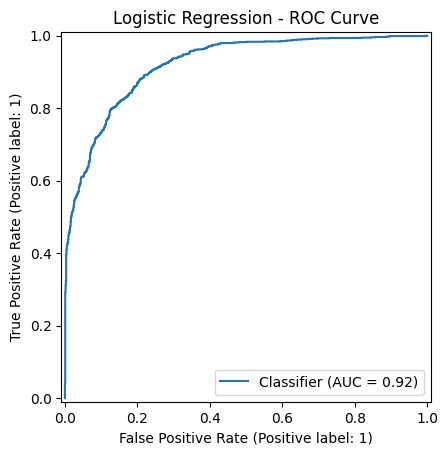



##### Tuning model: Linear SVM #####


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increas

Best params: {'C': 1, 'loss': 'hinge'}
Best CV F1: 0.8433
Tuning time: 1.95 seconds

Model: Linear SVM
Best Params: {'C': 1, 'loss': 'hinge'}
Best CV F1 Score: 0.8433
Test Accuracy : 0.8386
Test Precision: 0.8204
Test Recall   : 0.8670
Test F1-score : 0.8430
Test ROC-AUC  : 0.9164

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.81      0.83      1143
           1       0.82      0.87      0.84      1143

    accuracy                           0.84      2286
   macro avg       0.84      0.84      0.84      2286
weighted avg       0.84      0.84      0.84      2286

Confusion Matrix:
 [[926 217]
 [152 991]]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


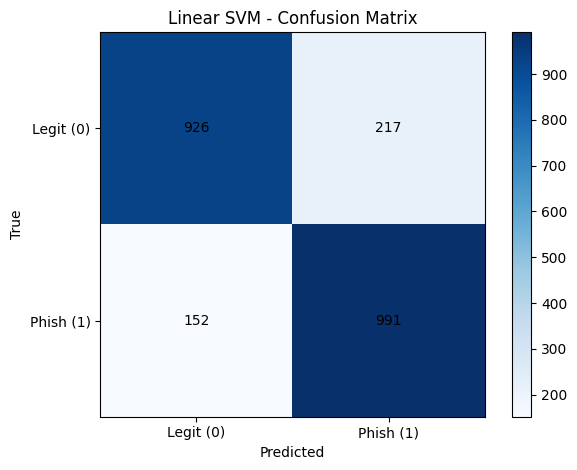

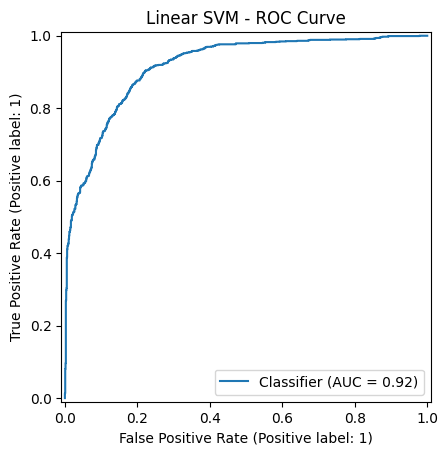



##### Tuning model: RBF SVM #####
Best params: {'C': 10, 'gamma': 'scale'}
Best CV F1: 0.8875
Tuning time: 4.72 seconds

Model: RBF SVM
Best Params: {'C': 10, 'gamma': 'scale'}
Best CV F1 Score: 0.8875
Test Accuracy : 0.8933
Test Precision: 0.8806
Test Recall   : 0.9099
Test F1-score : 0.8950
Test ROC-AUC  : 0.9609

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      1143
           1       0.88      0.91      0.90      1143

    accuracy                           0.89      2286
   macro avg       0.89      0.89      0.89      2286
weighted avg       0.89      0.89      0.89      2286

Confusion Matrix:
 [[1002  141]
 [ 103 1040]]


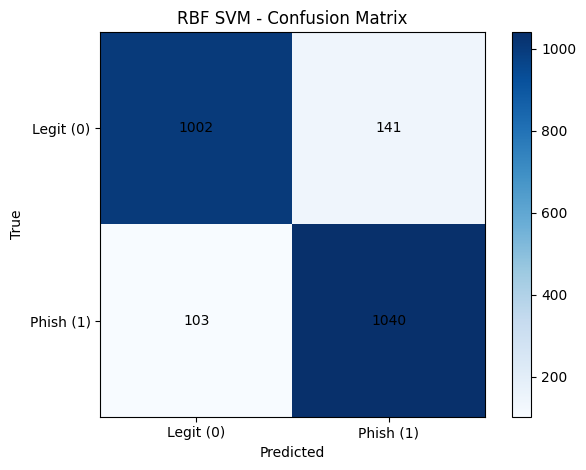

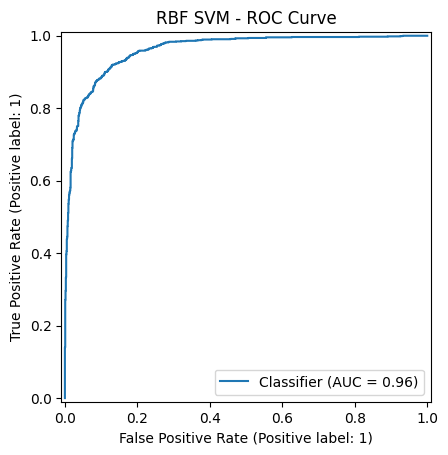



##### Tuning model: KNN #####
Best params: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Best CV F1: 0.8861
Tuning time: 2.93 seconds

Model: KNN
Best Params: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Best CV F1 Score: 0.8861
Test Accuracy : 0.8924
Test Precision: 0.8980
Test Recall   : 0.8854
Test F1-score : 0.8916
Test ROC-AUC  : 0.9561

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.89      1143
           1       0.90      0.89      0.89      1143

    accuracy                           0.89      2286
   macro avg       0.89      0.89      0.89      2286
weighted avg       0.89      0.89      0.89      2286

Confusion Matrix:
 [[1028  115]
 [ 131 1012]]


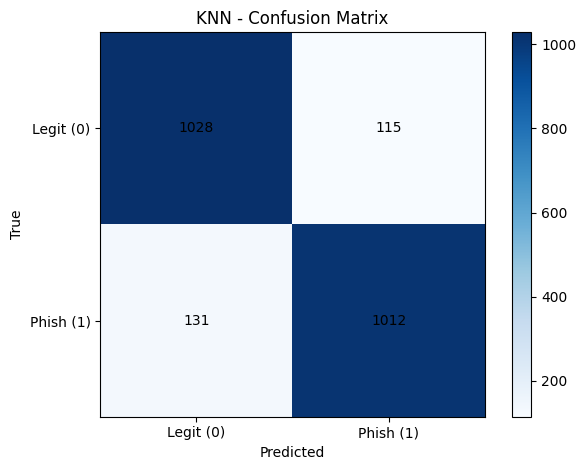

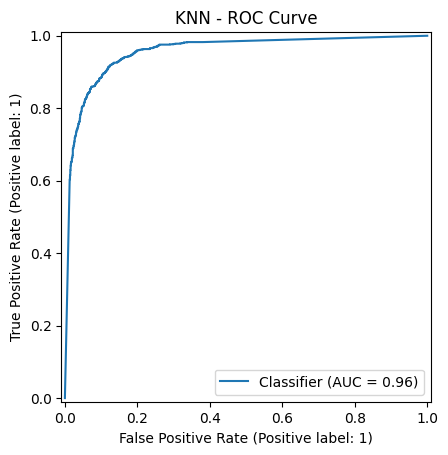



##### Tuning model: Gaussian NB #####
Best params: {'var_smoothing': 1e-07}
Best CV F1: 0.4968
Tuning time: 0.14 seconds

Model: Gaussian NB
Best Params: {'var_smoothing': 1e-07}
Best CV F1 Score: 0.4968
Test Accuracy : 0.6662
Test Precision: 0.9460
Test Recall   : 0.3526
Test F1-score : 0.5137
Test ROC-AUC  : 0.8523

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.98      0.75      1143
           1       0.95      0.35      0.51      1143

    accuracy                           0.67      2286
   macro avg       0.77      0.67      0.63      2286
weighted avg       0.77      0.67      0.63      2286

Confusion Matrix:
 [[1120   23]
 [ 740  403]]


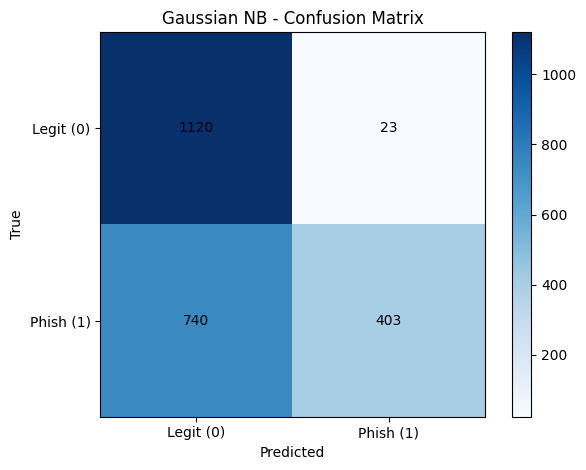

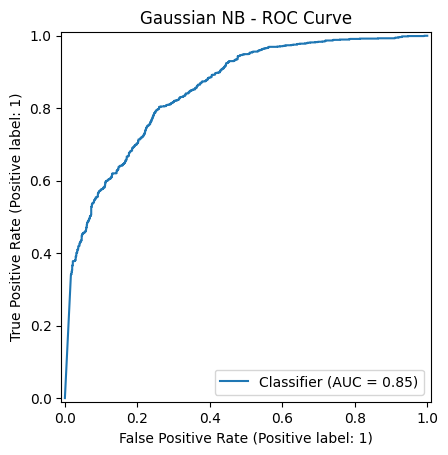



##### Tuning model: Random Forest #####
Best params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Best CV F1: 0.8976
Tuning time: 7.27 seconds

Model: Random Forest
Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Best CV F1 Score: 0.8976
Test Accuracy : 0.9086
Test Precision: 0.8938
Test Recall   : 0.9274
Test F1-score : 0.9103
Test ROC-AUC  : 0.9694

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.91      1143
           1       0.89      0.93      0.91      1143

    accuracy                           0.91      2286
   macro avg       0.91      0.91      0.91      2286
weighted avg       0.91      0.91      0.91      2286

Confusion Matrix:
 [[1017  126]
 [  83 1060]]


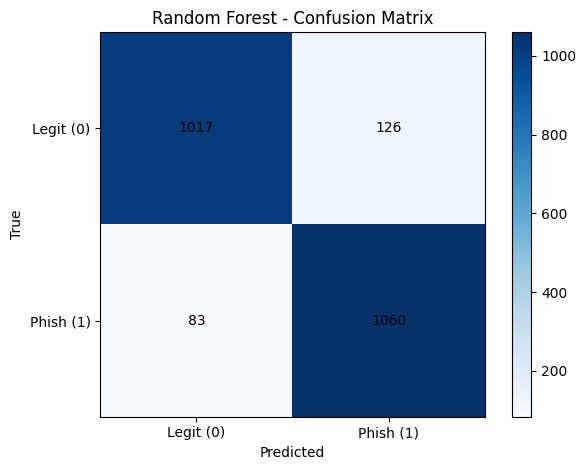

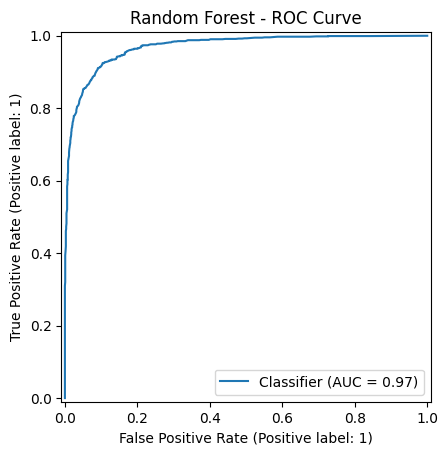



##### Tuning model: MLP Neural Net #####


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Best params: {'alpha': 0.0001, 'hidden_layer_sizes': (128,), 'learning_rate_init': 0.01}
Best CV F1: 0.8975
Tuning time: 18.24 seconds

Model: MLP Neural Net
Best Params: {'alpha': 0.0001, 'hidden_layer_sizes': (128,), 'learning_rate_init': 0.01}
Best CV F1 Score: 0.8975
Test Accuracy : 0.8976
Test Precision: 0.8862
Test Recall   : 0.9125
Test F1-score : 0.8991
Test ROC-AUC  : 0.9565

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      1143
           1       0.89      0.91      0.90      1143

    accuracy                           0.90      2286
   macro avg       0.90      0.90      0.90      2286
weighted avg       0.90      0.90      0.90      2286

Confusion Matrix:
 [[1009  134]
 [ 100 1043]]


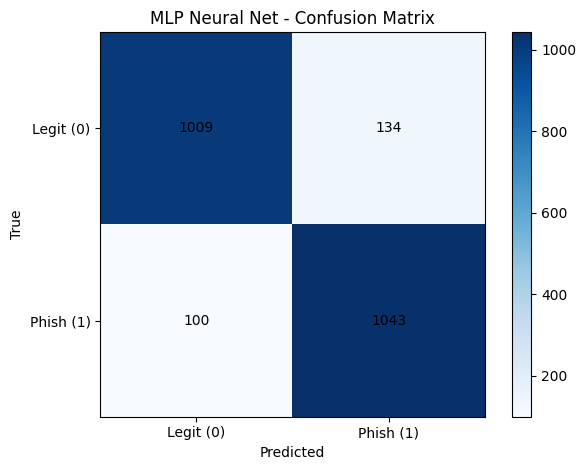

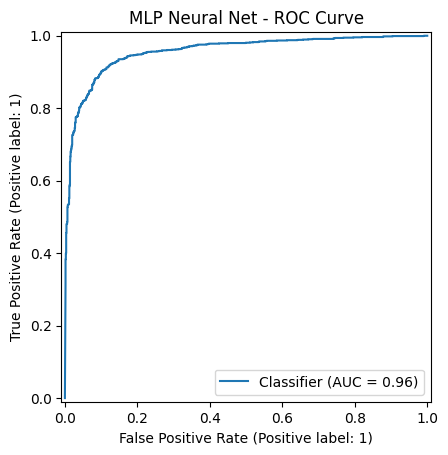

In [15]:
from time import time

metrics_log = []

for name, cfg in models_and_parameters.items():
    print(f"\n\n##### Tuning model: {name} #####")
    estimator = cfg["estimator"]
    param_grid = cfg["param_grid"]
    use_scaled = cfg["use_scaled"]

    X_tr = X_train_scaled if use_scaled else X_train
    X_te = X_test_scaled if use_scaled else X_test

    grid = GridSearchCV(
        estimator,
        param_grid,
        scoring="f1",
        cv=3,
        n_jobs=-1,
        verbose=0
    )

    start = time()
    grid.fit(X_tr, y_train)
    end = time()

    best_model = grid.best_estimator_
    best_params = grid.best_params_
    best_cv_score = grid.best_score_

    print(f"Best params: {best_params}")
    print(f"Best CV F1: {best_cv_score:.4f}")
    print(f"Tuning time: {end - start:.2f} seconds")

    evaluate_and_log(
        name=name,
        model=best_model,
        X_test_m=X_te,
        y_test=y_test,
        log_list=metrics_log,
        best_params=best_params,
        cv_best_score=best_cv_score
    )


In [16]:
metrics_df = pd.DataFrame(metrics_log)
metrics_df_sorted = metrics_df.sort_values(by="test_f1", ascending=False).reset_index(drop=True)

print("\n\n===== Consolidated Metrics Log (sorted by Test F1) =====")
display(metrics_df_sorted)




===== Consolidated Metrics Log (sorted by Test F1) =====


,model,best_params,cv_best_f1,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,Random Forest,"{'max_depth': None, 'min_samples_split': 2, 'n...",0.897614,0.908574,0.893761,0.927384,0.910262,0.969370
1,MLP Neural Net,"{'alpha': 0.0001, 'hidden_layer_sizes': (128,)...",0.897456,0.897638,0.886151,0.912511,0.899138,0.956519
2,RBF SVM,"{'C': 10, 'gamma': 'scale'}",0.887465,0.893263,0.880610,0.909886,0.895009,0.960879
3,KNN,"{'metric': 'manhattan', 'n_neighbors': 7, 'wei...",0.886094,0.892388,0.897959,0.885389,0.891630,0.956078
4,Linear SVM,"{'C': 1, 'loss': 'hinge'}",0.843327,0.838583,0.820364,0.867017,0.843046,0.916381
5,Logistic Regression,"{'C': 1, 'class_weight': None}",0.833632,0.831146,0.824336,0.841645,0.832900,0.920575
6,Gaussian NB,{'var_smoothing': 1e-07},0.496757,0.666229,0.946009,0.352581,0.513703,0.852325


## 5. Summary

- Loads `dataset_phishing.csv` and keeps only `url` and `status`.
- Encodes `status` into a binary phishing label.
- Performs **heavy URL-based feature engineering** (50+ features), including:
  - Lexical patterns (lengths, character counts, entropy, structure).
  - Domain-based attributes (TLD, subdomains, digits, hyphens).
  - Optional WHOIS and SSL certificate-related signals.
- Conducts basic EDA on the engineered feature space.
- Trains and tunes:
  - 5 classical ML models,
  - 1 ensemble model (Random Forest),
  - 1 neural network (MLPClassifier).
- Evaluates each model with accuracy, precision, recall, F1-score, and ROC-AUC.
- Logs metrics for all models in a single comparison table.
